In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
!pip install yfinance

In [1]:
import keras
import math
import numpy as np
import random
from collections import deque
import random
from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import yfinance as yf
import sys
sys.path.append('../') 
import pandas as pd

In [2]:
start_date = '2021-01-01'
end_date = '2023-12-31'
df_stock = yf.download('MSFT', start=start_date, end= end_date)
df_stock

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605316,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317337,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188553,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200
...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400


In [3]:
esg_news_scores = pd.read_csv('../data/ESG_news_scores.csv')
esg_news_scores = esg_news_scores[['date','predicted_class','vader_score']]
esg_news_scores

,date,predicted_class,vader_score
0,2018-01-08,Environmental,0.572003
1,2018-01-08,Social,0.589700
2,2018-01-23,Environmental,0.219825
3,2018-01-23,Social,0.411834
4,2018-01-25,Social,0.077200
...,...,...,...
750,2023-12-18,Social,0.424027
751,2023-12-19,Environmental,0.286562
752,2023-12-19,Social,0.750600
753,2023-12-20,Environmental,0.424680


In [4]:
esg_reports_scores = pd.read_csv('../data/ESG_reports_scores.csv')
esg_reports_scores = esg_reports_scores[['Year','predicted_class','vader_score']]
esg_reports_scores

,Year,predicted_class,vader_score
0,2003,Environmental,-0.026744
1,2003,Governance,0.253578
2,2003,Social,0.445030
3,2005,Environmental,0.279450
4,2005,Governance,0.519736
5,2005,Social,0.482264
6,2006,Environmental,0.438680
7,2006,Governance,0.263533
8,2006,Social,0.500849
9,2007,Environmental,0.359280


In [5]:
# Pivot the DataFrame
df_reports_sentiment = esg_reports_scores.pivot_table(index='Year', columns='predicted_class', values='vader_score', aggfunc='first')
df_reports_sentiment

predicted_class,Environmental,Governance,Social
Year,,,
2003,-0.026744,0.253578,0.445030
2005,0.279450,0.519736,0.482264
2006,0.438680,0.263533,0.500849
2007,0.359280,0.210750,0.518255
2010,0.376140,0.328150,0.440654
2011,0.355380,0.118046,0.468392
2012,0.439455,0.262200,0.445918
2013,0.399802,0.222333,0.417180
2014,0.286816,0.339159,0.426923


In [6]:
# Pivot the DataFrame
df_sentiment = esg_news_scores.pivot_table(index='date', columns='predicted_class', values='vader_score', aggfunc='first')
df_sentiment

predicted_class,Environmental,Governance,Social
date,,,
2018-01-08,0.572003,NaN,0.589700
2018-01-23,0.219825,NaN,0.411834
2018-01-25,NaN,NaN,0.077200
2018-01-26,0.592122,NaN,0.817600
2018-02-22,0.157500,NaN,0.447729
...,...,...,...
2023-12-14,0.293227,NaN,NaN
2023-12-18,0.406170,NaN,0.424027
2023-12-19,0.286562,NaN,0.750600


In [7]:
# Normalize indices if there are time components
df_stock.index = pd.to_datetime(df_stock.index).normalize()
df_sentiment.index = pd.to_datetime(df_sentiment.index).normalize()

merged_df = pd.merge(df_stock, df_sentiment, left_index=True, right_index=True, how='outer')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Environmental,Governance,Social
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,0.572003,NaN,0.589700
2018-01-23,NaN,NaN,NaN,NaN,NaN,NaN,0.219825,NaN,0.411834
2018-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077200
2018-01-26,NaN,NaN,NaN,NaN,NaN,NaN,0.592122,NaN,0.817600
2018-02-22,NaN,NaN,NaN,NaN,NaN,NaN,0.157500,NaN,0.447729
...,...,...,...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100.0,NaN,NaN,NaN
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100.0,NaN,NaN,NaN
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400.0,NaN,NaN,NaN
2023-12-28,375.369995,376.459991,374.160004,375.279999,374.587280,14327000.0,0.000000,NaN,NaN


In [8]:
# Assuming df_stock and df_sentiment are your DataFrames
df_stock.index = pd.to_datetime(df_stock.index)
df_sentiment.index = pd.to_datetime(df_sentiment.index)

df_stock.sort_index(inplace=True)
df_sentiment.sort_index(inplace=True)
# Find the closest future trading day for each news date
def get_next_trading_day(news_date, trading_days):
    future_days = trading_days[trading_days >= news_date]
    if not future_days.empty:
        return future_days[0]
    return None

# List of trading days to look up against
trading_days = df_stock.index

# Apply this function to the sentiment dates
df_sentiment['trading_day'] = df_sentiment.index.map(lambda date: get_next_trading_day(date, trading_days))

# Drop original date index and set the new trading day as index
df_sentiment.reset_index(drop=True, inplace=True)
df_sentiment.set_index('trading_day', inplace=True)


In [9]:
# Merge with an outer join to ensure all data is captured
merged_df = pd.merge(df_stock, df_sentiment, left_index=True, right_index=True, how='left')

# If there are multiple sentiment entries for a single day, average them
merged_df = merged_df.groupby(merged_df.index).agg({
    'Open': 'first',
    'High': 'first',
    'Low': 'first',
    'Close': 'first',
    'Adj Close': 'first',
    'Volume': 'first',
    'Environmental': 'mean',     # Averaging overlapping values
    'Governance': 'mean',
    'Social': 'mean'
})
merged_df

,Open,High,Low,Close,Adj Close,Volume,Environmental,Governance,Social
2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605316,37130100,0.341237,0.487337,0.325431
2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000,NaN,NaN,NaN
2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317337,35930700,NaN,NaN,NaN
2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188553,27694500,NaN,NaN,NaN
2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100,NaN,NaN,NaN
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100,NaN,NaN,NaN
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400,NaN,NaN,NaN
2023-12-28,375.369995,376.459991,374.160004,375.279999,374.587280,14327000,0.000000,NaN,NaN


In [10]:
merged_df_copy = merged_df.copy()
annual_scores_df = df_reports_sentiment.copy()

In [11]:
import pandas as pd

# Assuming Date is the index in merged_df and it's in datetime format
# If Date is not a datetime index:
merged_df_copy.index = pd.to_datetime(merged_df_copy.index)

# Extract year from index for mapping
merged_df_copy['Year'] = merged_df_copy.index.year

# Define columns to work with
columns_to_impute = ['Environmental', 'Governance', 'Social']

for col in columns_to_impute:
    # Map annual scores to each day
    annual_score_map = merged_df_copy['Year'].map(annual_scores_df[col])
    
    # Fill NaN values with mapped annual scores
    # Also, where values exist, average them with the mapped annual scores
    merged_df_copy[col] = merged_df_copy[col].combine_first(annual_score_map)  # Fill NaNs with annual scores
    merged_df_copy[col] = (merged_df_copy[col] + annual_score_map) / 2  # Average existing with annual

# Clean up by removing the Year column if no longer needed
merged_df_copy.drop(columns=['Year'], inplace=True)

# Verify the results
merged_df_copy.head()


,Open,High,Low,Close,Adj Close,Volume,Environmental,Governance,Social
2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605316,37130100,0.291540,0.383360,0.357716
2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000,0.241842,0.279383,0.390002
2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317337,35930700,0.241842,0.279383,0.390002
2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188553,27694500,0.241842,0.279383,0.390002
2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200,0.241842,0.279383,0.390002


In [12]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace
import numpy as np
import math
import random
from collections import deque
from IPython.core.debugger import set_trace
from keras.layers import Input
import itertools

# Assuming 'dataset' is your DataFrame with the historical stock data
data = merged_df_copy.values

# Normalize data if necessary
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Let's say you have daily stock data
num_data = len(data)
train_cutoff = int(num_data * 0.7)  # 70% for training
validation_cutoff = int(num_data * 0.85)  # Additional 15% for validation

X_train = data[:train_cutoff]
X_val = data[train_cutoff:validation_cutoff]
X_test = data[validation_cutoff:]

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (527, 9)
Validation Data Shape: (113, 9)
Testing Data Shape: (113, 9)


## Helper Functions

In [36]:
# Function to format the price for printing
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -100, 100)))  # Clip values to prevent overflow

def getState(data, t, window_size):
    # Assuming ESG features are at the last three columns in the data
    d = t - window_size + 1
    if d < 0:
        block = np.pad(data[:t + 1], ((abs(d), 0), (0, 0)), 'constant', constant_values=(0))
    else:
        block = data[d:t + 1]

    res = [sigmoid(block[i + 1, 3] - block[i, 3]) for i in range(min(len(block) - 1, window_size - 1))]  # Price change
    esg = block[-1, -3:]  # Last row, last three columns for ESG scores

    # Include ESG scores directly or transformed (e.g., normalized or sigmoid-scaled)
    esg_transformed = [sigmoid(score) for score in esg]
    res.extend(esg_transformed)  # Adding ESG features to the state

    if len(res) < window_size - 1 + 3:  # Ensure padding if necessary
        res = [0] * (window_size - 1 + 3 - len(res)) + res

    return np.array([res]).reshape(1, -1)

def plot_behavior(data_input, states_buy, states_sell, profit):
    # Assuming data_input is a 2D array with 6 features, where the 'Close' price is the 4th column (index 3)
    #close_prices = data_input[:, 3]  # Extracting the 'Close' prices

    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)  # Plot the 'Close' price line

    # Mark the buy and sell points
    # markevery parameter expects a list of indices, here we directly use states_buy and states_sell
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)

    plt.title('Total gains: %f' % profit)
    plt.legend()
    plt.show()

## Agent class definition

In [34]:
import itertools
class Agent:
    def __init__(self, state_size, window_size, model_name="", is_eval=False):
        self.state_size = state_size
        self.action_size = 3  # sit, buy, sell
        self.memory = deque(maxlen=2000)  # Increased memory size
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # More aggressive decay
        self.learning_rate = 0.001  # Initial learning rate
        self.learning_rate_decay = 0.999  # Learning rate decay
        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        # Adjust the input shape to include ESG features
        model.add(Input(shape=(self.state_size + 3,)))  # Added 3 for ESG
        model.add(Dense(units=64, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=16, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        states = np.zeros((len(mini_batch), self.state_size))
        next_states = np.zeros((len(mini_batch), self.state_size))

        for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
            if state.shape == (1, self.state_size) and next_state.shape == (1, self.state_size):
                states[i] = state
                next_states[i] = next_state
            else:
                continue  # Skip any invalid states

        # Proceed with the calculation only if there are valid states
        if np.any(states):
            target_f = self.model.predict(states)
            next_Q_values = self.model.predict(next_states)
            for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(next_Q_values[i])
                target_f[i][action] = target

            # Fit the model
            self.model.fit(states, target_f, epochs=1, verbose=0)

## Training set up

Running episode 0/10
Buy: -$1.70
Sell: -$1.70 | Profit: $0.01
Buy: -$1.84
Sell: -$1.69 | Profit: $0.15
Buy: -$1.52
Buy: -$1.41
Sell: -$1.32 | Profit: $0.20
Buy: -$1.17
Sell: -$1.16 | Profit: $0.25
Sell: -$1.16 | Profit: $0.01
Buy: -$1.09
Sell: -$1.05 | Profit: $0.04
Buy: -$1.02
Buy: -$1.06
Buy: -$1.05
Sell: -$1.28 | Profit: -$0.26
Buy: -$1.32
Buy: -$1.42
Sell: -$1.30 | Profit: -$0.24
Buy: -$1.48
Sell: -$1.36 | Profit: -$0.30
Buy: -$1.46
Buy: -$1.30
Buy: -$1.34
Sell: -$1.22 | Profit: $0.10
Buy: -$1.25
Sell: -$1.28 | Profit: $0.14
Buy: -$1.20
Sell: -$1.22 | Profit: $0.26
Buy: -$1.38
Sell: -$1.25 | Profit: $0.21
Sell: -$1.21 | Profit: $0.09
Sell: -$1.34 | Profit: -$0.00
Buy: -$1.24
Sell: -$1.27 | Profit: -$0.01
Buy: -$1.09
Buy: -$0.92
Sell: -$0.95 | Profit: $0.25
Sell: -$0.82 | Profit: $0.56
Buy: -$0.75
Buy: -$0.76
Buy: -$0.63
Sell: -$0.68 | Profit: $0.55
Buy: -$0.69
Buy: -$0.64
Buy: -$0.72
Sell: -$0.62 | Profit: $0.47
Buy: -$0.61
Buy: -$0.60
Sell: -$0.79 | Profit: $0.14
Buy: -$0.84
Sell:

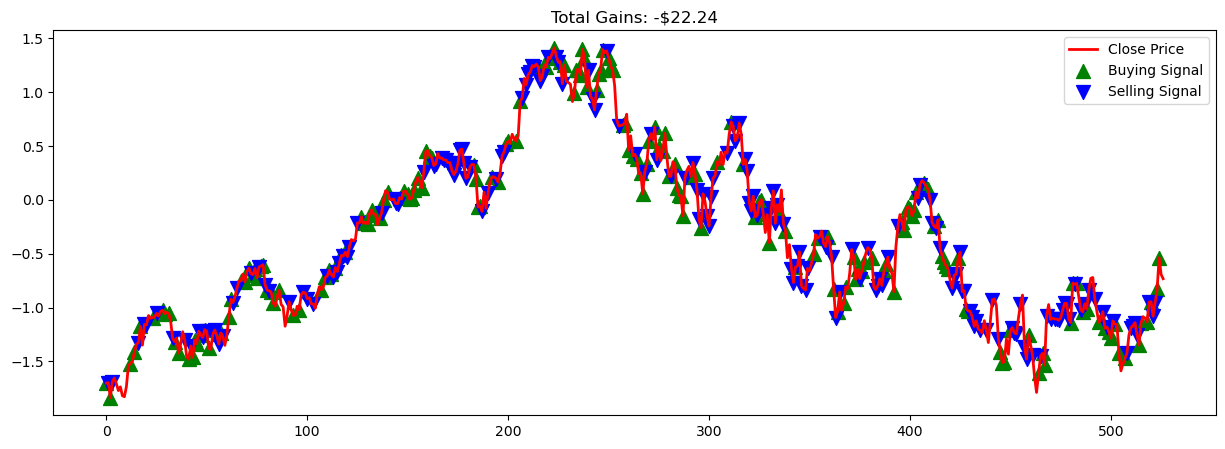

Running episode 1/10
Buy: -$1.70
Buy: -$1.84
Buy: -$1.69
Buy: -$1.77
Sell: -$1.82 | Profit: -$0.12
Buy: -$1.83
Buy: -$1.54
Buy: -$1.52
Buy: -$1.50
Buy: -$1.41
Buy: -$1.34
Sell: -$1.17 | Profit: $0.66
Sell: -$1.35 | Profit: $0.34
Buy: -$1.16
Buy: -$1.07
Buy: -$1.10
Buy: -$1.09
Sell: -$1.05 | Profit: $0.72
Buy: -$1.08
Sell: -$1.02 | Profit: $0.80
Buy: -$1.04
Buy: -$1.12
Sell: -$1.32 | Profit: $0.22
Buy: -$1.28
Buy: -$1.42
Sell: -$1.34 | Profit: $0.18
Sell: -$1.46 | Profit: $0.04
Sell: -$1.48 | Profit: -$0.07
Sell: -$1.46 | Profit: -$0.12
Sell: -$1.30 | Profit: -$0.15
Buy: -$1.34
Sell: -$1.22 | Profit: -$0.15
Buy: -$1.25
Buy: -$1.28
Buy: -$1.20
Buy: -$1.22
Sell: -$1.39 | Profit: -$0.29
Buy: -$1.25
Sell: -$1.21 | Profit: -$0.11
Sell: -$1.26 | Profit: -$0.18
Buy: -$1.34
Buy: -$1.24
Buy: -$1.27
Buy: -$1.35
Sell: -$1.25 | Profit: -$0.21
Sell: -$0.92 | Profit: $0.20
Sell: -$0.95 | Profit: $0.33
Buy: -$0.90
Sell: -$0.82 | Profit: $0.60
Sell: -$0.75 | Profit: $0.58
Buy: -$0.76
Sell: -$0.66 | Pro

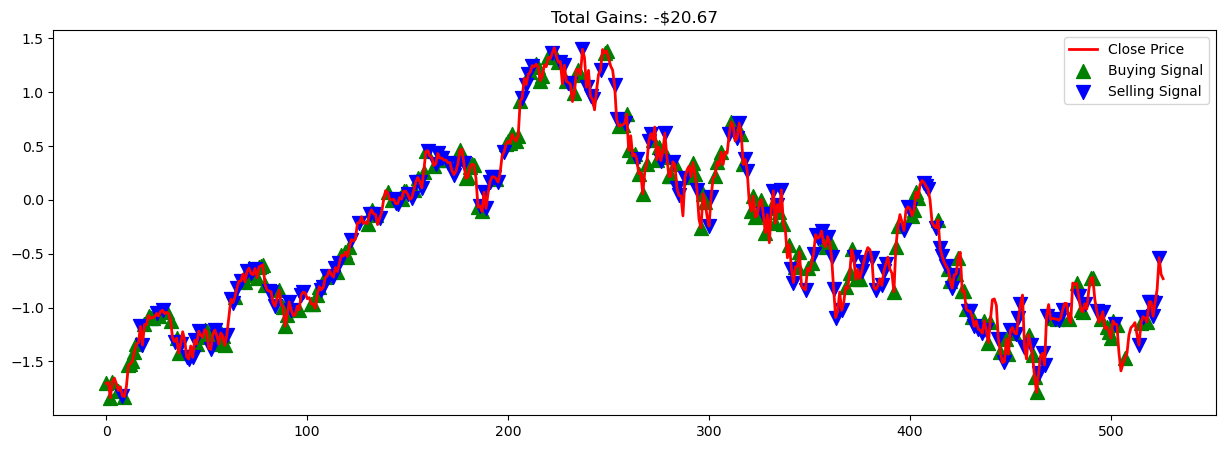

Running episode 2/10
Buy: -$1.70
Sell: -$1.84 | Profit: -$0.14
Buy: -$1.65
Buy: -$1.77
Sell: -$1.74 | Profit: -$0.08
Buy: -$1.83
Sell: -$1.73 | Profit: $0.04
Sell: -$1.54 | Profit: $0.29
Buy: -$1.41
Sell: -$1.34 | Profit: $0.07
Buy: -$1.32
Buy: -$1.16
Sell: -$1.16 | Profit: $0.16
Sell: -$1.10 | Profit: $0.06
Buy: -$1.09
Sell: -$1.05 | Profit: $0.03
Buy: -$1.06
Buy: -$1.04
Buy: -$1.05
Sell: -$1.28 | Profit: -$0.23
Buy: -$1.42
Buy: -$1.34
Buy: -$1.48
Sell: -$1.46 | Profit: -$0.42
Sell: -$1.30 | Profit: -$0.25
Buy: -$1.34
Buy: -$1.22
Sell: -$1.25 | Profit: $0.17
Sell: -$1.20 | Profit: $0.13
Buy: -$1.22
Sell: -$1.38 | Profit: $0.10
Buy: -$1.39
Sell: -$1.25 | Profit: $0.09
Buy: -$1.21
Buy: -$1.26
Buy: -$1.24
Buy: -$1.35
Sell: -$0.95 | Profit: $0.27
Sell: -$0.82 | Profit: $0.40
Sell: -$0.75 | Profit: $0.63
Sell: -$0.69 | Profit: $0.52
Sell: -$0.76 | Profit: $0.50
Sell: -$0.68 | Profit: $0.55
Sell: -$0.64 | Profit: $0.71
Buy: -$0.72
Sell: -$0.60 | Profit: $0.12
Buy: -$0.84
Buy: -$0.85
Sell: -

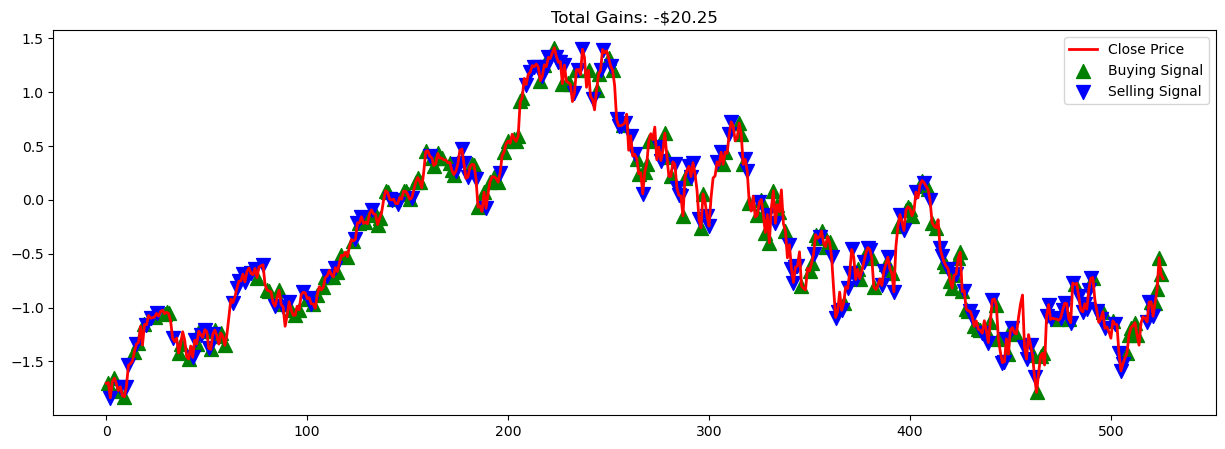

Running episode 3/10
Buy: -$1.70
Buy: -$1.65
Buy: -$1.71
Buy: -$1.74
Sell: -$1.82 | Profit: -$0.12
Sell: -$1.52 | Profit: $0.13
Buy: -$1.50
Sell: -$1.32 | Profit: $0.38
Buy: -$1.17
Buy: -$1.16
Buy: -$1.16
Buy: -$1.07
Sell: -$1.09 | Profit: $0.65
Sell: -$1.08 | Profit: $0.42
Sell: -$1.04 | Profit: $0.14
Buy: -$1.02
Buy: -$1.06
Sell: -$1.05 | Profit: $0.10
Sell: -$1.28 | Profit: -$0.12
Buy: -$1.28
Buy: -$1.42
Buy: -$1.34
Sell: -$1.22 | Profit: -$0.15
Buy: -$1.46
Buy: -$1.48
Buy: -$1.30
Sell: -$1.34 | Profit: -$0.31
Sell: -$1.22 | Profit: -$0.16
Sell: -$1.28 | Profit: $0.01
Buy: -$1.38
Sell: -$1.25 | Profit: $0.17
Buy: -$1.21
Sell: -$1.26 | Profit: $0.08
Sell: -$1.34 | Profit: $0.12
Sell: -$1.24 | Profit: $0.24
Sell: -$1.35 | Profit: -$0.05
Sell: -$1.09 | Profit: $0.29
Buy: -$0.92
Buy: -$0.95
Buy: -$0.90
Buy: -$0.82
Buy: -$0.75
Sell: -$0.63 | Profit: $0.58
Sell: -$0.69 | Profit: $0.23
Buy: -$0.72
Buy: -$0.62
Buy: -$0.61
Sell: -$0.60 | Profit: $0.35
Buy: -$0.79
Sell: -$0.85 | Profit: $0.05

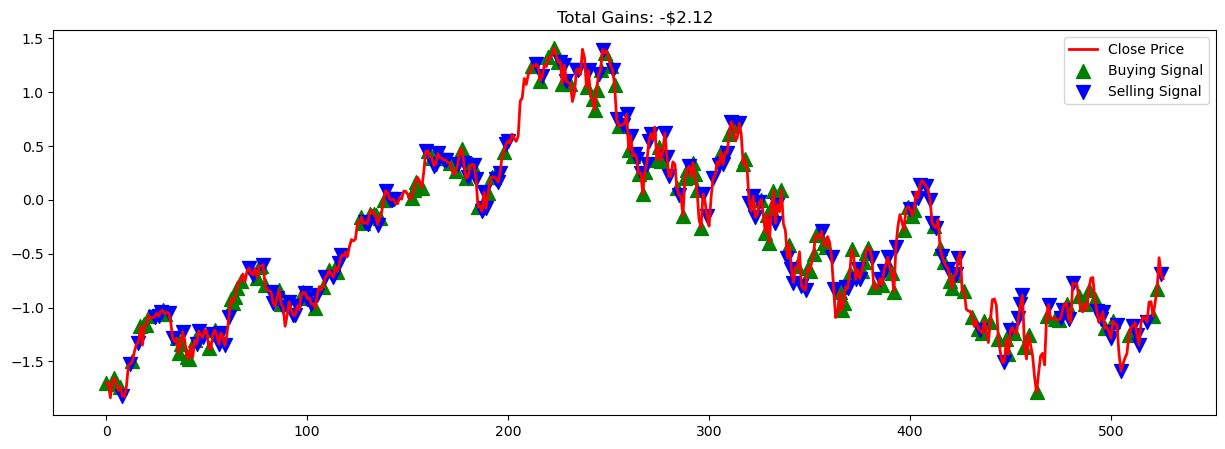

Running episode 4/10
Buy: -$1.69
Sell: -$1.65 | Profit: $0.03
Buy: -$1.52
Sell: -$1.50 | Profit: $0.02
Buy: -$1.32
Buy: -$1.35
Sell: -$1.07 | Profit: $0.25
Sell: -$1.10 | Profit: $0.25
Buy: -$1.05
Buy: -$1.06
Buy: -$1.04
Buy: -$1.05
Sell: -$1.12 | Profit: -$0.07
Buy: -$1.28
Sell: -$1.32 | Profit: -$0.26
Buy: -$1.42
Buy: -$1.34
Sell: -$1.22 | Profit: -$0.18
Sell: -$1.30 | Profit: -$0.25
Buy: -$1.46
Buy: -$1.48
Buy: -$1.36
Sell: -$1.46 | Profit: -$0.18
Sell: -$1.30 | Profit: $0.12
Sell: -$1.22 | Profit: $0.12
Sell: -$1.25 | Profit: $0.20
Buy: -$1.20
Sell: -$1.39 | Profit: $0.09
Buy: -$1.25
Sell: -$1.21 | Profit: $0.15
Sell: -$1.26 | Profit: -$0.06
Buy: -$1.24
Sell: -$1.27 | Profit: -$0.02
Buy: -$1.35
Buy: -$1.25
Buy: -$0.95
Sell: -$0.75 | Profit: $0.48
Buy: -$0.69
Sell: -$0.76 | Profit: $0.59
Sell: -$0.66 | Profit: $0.59
Sell: -$0.63 | Profit: $0.32
Sell: -$0.68 | Profit: $0.01
Buy: -$0.72
Buy: -$0.62
Buy: -$0.61
Buy: -$0.60
Sell: -$0.79 | Profit: -$0.06
Buy: -$0.84
Buy: -$0.85
Sell: -$0

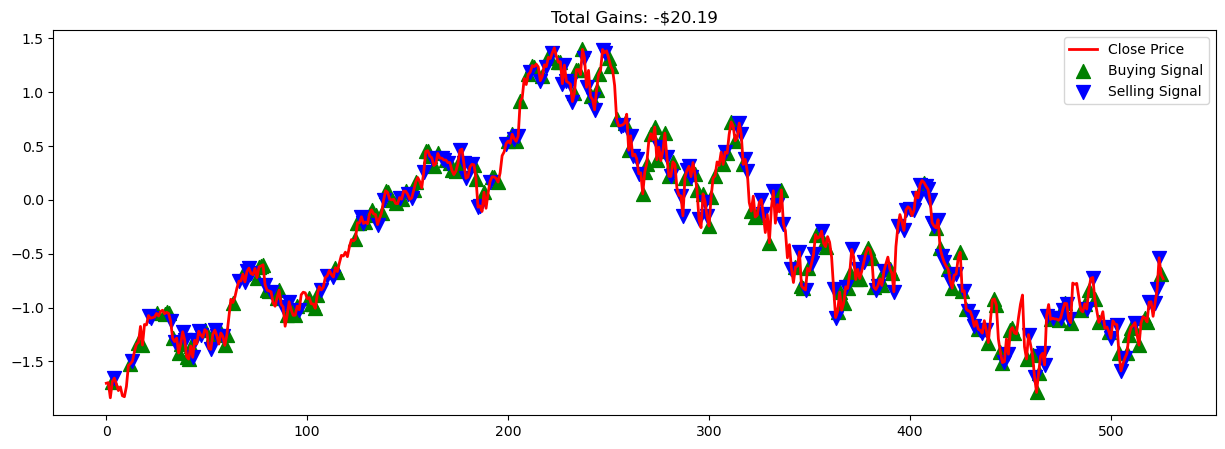

Running episode 5/10
Buy: -$1.84
Buy: -$1.69
Sell: -$1.65 | Profit: $0.18
Buy: -$1.77
Buy: -$1.83
Sell: -$1.73 | Profit: -$0.05
Sell: -$1.52 | Profit: $0.25
Buy: -$1.41
Sell: -$1.32 | Profit: $0.50
Sell: -$1.17 | Profit: $0.23
Buy: -$1.16
Sell: -$1.10 | Profit: $0.06
Buy: -$1.09
Buy: -$1.05
Sell: -$1.08 | Profit: $0.01
Buy: -$1.02
Sell: -$1.06 | Profit: -$0.00
Sell: -$1.05 | Profit: -$0.03
Buy: -$1.32
Buy: -$1.28
Buy: -$1.22
Sell: -$1.30 | Profit: $0.01
Sell: -$1.36 | Profit: -$0.07
Buy: -$1.30
Buy: -$1.34
Sell: -$1.22 | Profit: $0.00
Sell: -$1.28 | Profit: $0.03
Buy: -$1.38
Buy: -$1.39
Buy: -$1.25
Sell: -$1.21 | Profit: $0.13
Sell: -$1.34 | Profit: $0.04
Sell: -$1.24 | Profit: $0.15
Sell: -$1.27 | Profit: -$0.02
Buy: -$1.09
Sell: -$0.95 | Profit: $0.14
Buy: -$0.82
Sell: -$0.75 | Profit: $0.07
Buy: -$0.68
Sell: -$0.69 | Profit: -$0.01
Buy: -$0.85
Buy: -$0.85
Buy: -$0.95
Sell: -$0.99 | Profit: -$0.14
Buy: -$0.91
Sell: -$0.99 | Profit: -$0.14
Buy: -$1.02
Buy: -$1.07
Buy: -$0.99
Buy: -$1.

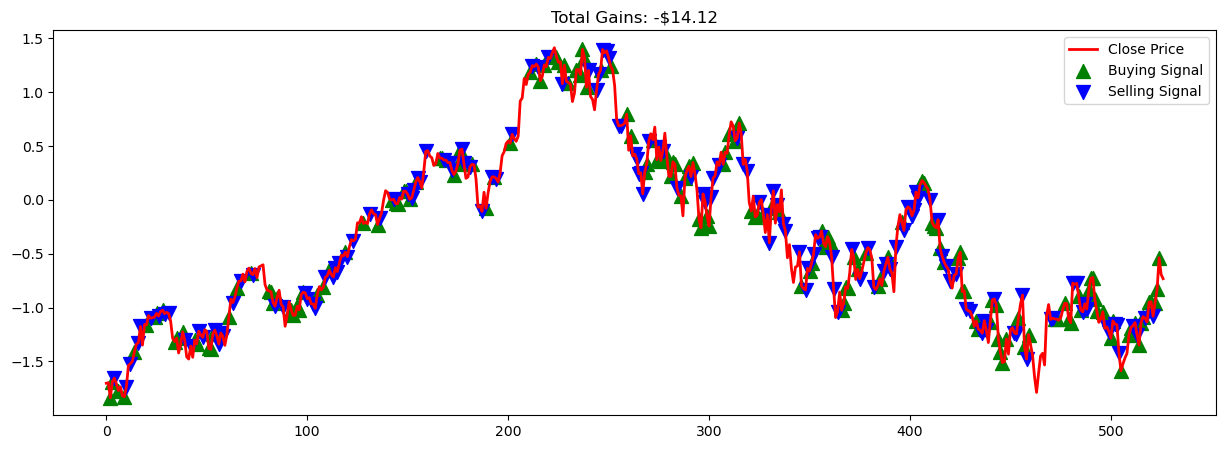

Running episode 6/10
Buy: -$1.41
Sell: -$1.34 | Profit: $0.07
Buy: -$1.32
Sell: -$1.17 | Profit: $0.15
Buy: -$1.16
Buy: -$1.16
Sell: -$1.07 | Profit: $0.08
Buy: -$1.10
Buy: -$1.09
Buy: -$1.08
Buy: -$1.04
Sell: -$1.02 | Profit: $0.14
Buy: -$1.06
Sell: -$1.12 | Profit: -$0.03
Sell: -$1.28 | Profit: -$0.20
Sell: -$1.42 | Profit: -$0.34
Sell: -$1.34 | Profit: -$0.30
Sell: -$1.22 | Profit: -$0.17
Buy: -$1.48
Sell: -$1.46 | Profit: $0.02
Buy: -$1.30
Buy: -$1.20
Sell: -$1.22 | Profit: $0.08
Buy: -$1.38
Buy: -$1.39
Buy: -$1.25
Buy: -$1.21
Sell: -$1.26 | Profit: -$0.06
Sell: -$1.34 | Profit: $0.04
Sell: -$1.24 | Profit: $0.15
Buy: -$1.27
Buy: -$1.35
Buy: -$1.25
Buy: -$1.09
Sell: -$0.92 | Profit: $0.32
Sell: -$0.95 | Profit: $0.26
Sell: -$0.82 | Profit: $0.45
Buy: -$0.75
Buy: -$0.76
Sell: -$0.66 | Profit: $0.69
Sell: -$0.63 | Profit: $0.62
Buy: -$0.68
Sell: -$0.69 | Profit: $0.40
Buy: -$0.64
Sell: -$0.72 | Profit: $0.03
Buy: -$0.62
Buy: -$0.61
Sell: -$0.60 | Profit: $0.16
Buy: -$0.79
Buy: -$0.85

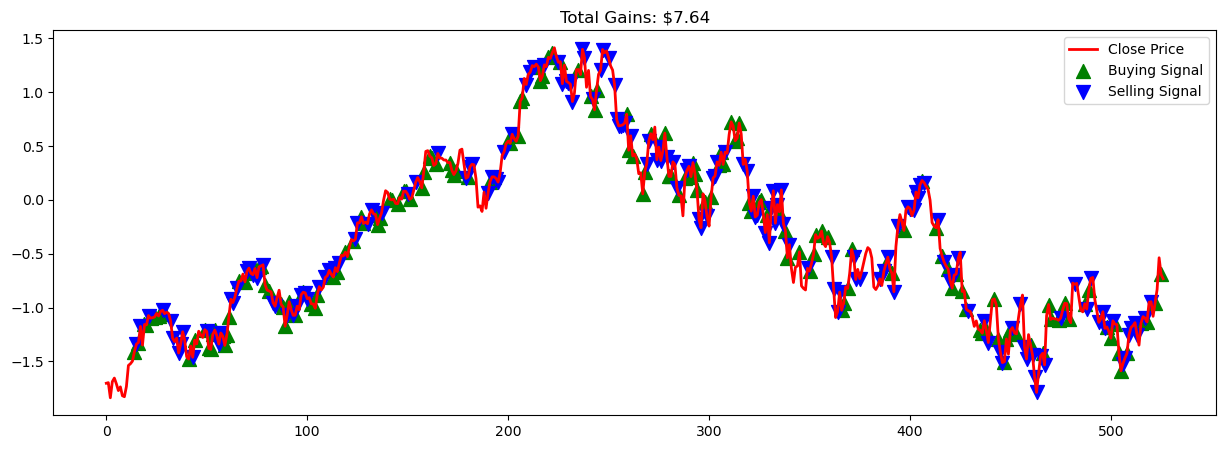

Running episode 7/10
Buy: -$1.70
Sell: -$1.84 | Profit: -$0.14
Buy: -$1.65
Sell: -$1.77 | Profit: -$0.12
Buy: -$1.83
Sell: -$1.73 | Profit: $0.09
Buy: -$1.54
Buy: -$1.52
Sell: -$1.50 | Profit: $0.04
Sell: -$1.41 | Profit: $0.11
Buy: -$1.17
Sell: -$1.35 | Profit: -$0.17
Buy: -$1.16
Sell: -$1.07 | Profit: $0.09
Buy: -$1.09
Sell: -$1.05 | Profit: $0.04
Buy: -$1.04
Sell: -$1.04 | Profit: -$0.01
Buy: -$1.12
Sell: -$1.28 | Profit: -$0.16
Buy: -$1.32
Buy: -$1.28
Sell: -$1.34 | Profit: -$0.02
Sell: -$1.22 | Profit: $0.06
Buy: -$1.48
Buy: -$1.46
Buy: -$1.34
Sell: -$1.22 | Profit: $0.26
Sell: -$1.25 | Profit: $0.21
Sell: -$1.38 | Profit: -$0.04
Buy: -$1.21
Sell: -$1.26 | Profit: -$0.05
Buy: -$1.34
Buy: -$1.27
Buy: -$1.25
Sell: -$1.09 | Profit: $0.25
Sell: -$0.92 | Profit: $0.34
Sell: -$0.95 | Profit: $0.30
Buy: -$0.76
Buy: -$0.66
Buy: -$0.68
Sell: -$0.64 | Profit: $0.12
Sell: -$0.72 | Profit: -$0.06
Sell: -$0.62 | Profit: $0.06
Buy: -$0.84
Buy: -$0.85
Sell: -$0.85 | Profit: -$0.02
Buy: -$0.95
Se

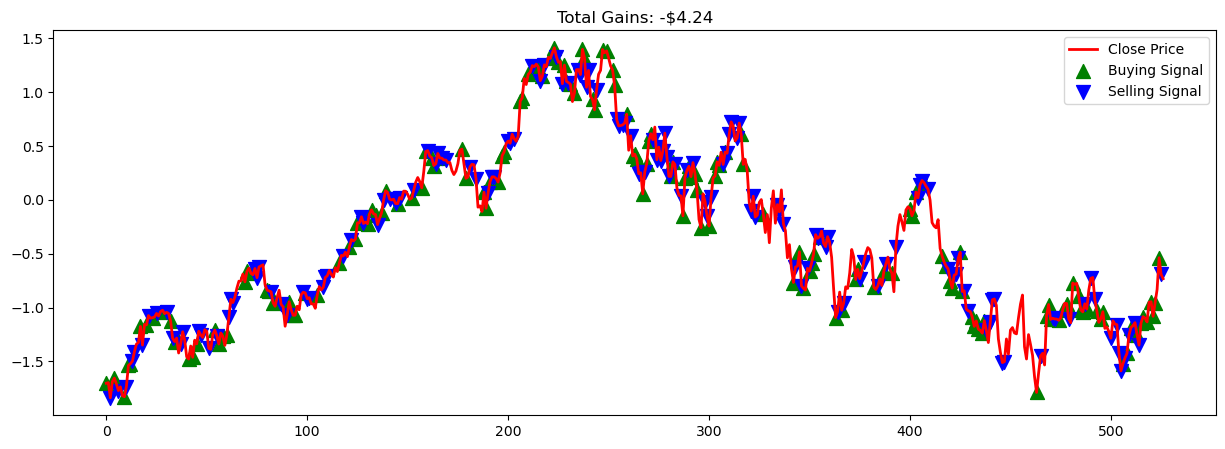

Running episode 8/10
Buy: -$1.70
Buy: -$1.84
Sell: -$1.65 | Profit: $0.05
Sell: -$1.77 | Profit: $0.07
Buy: -$1.82
Sell: -$1.73 | Profit: $0.08
Buy: -$1.50
Buy: -$1.34
Sell: -$1.32 | Profit: $0.17
Buy: -$1.17
Buy: -$1.35
Buy: -$1.16
Sell: -$1.16 | Profit: $0.18
Buy: -$1.09
Sell: -$1.09 | Profit: $0.09
Buy: -$1.05
Sell: -$1.02 | Profit: $0.32
Buy: -$1.06
Sell: -$1.04 | Profit: $0.11
Sell: -$1.12 | Profit: -$0.03
Buy: -$1.32
Sell: -$1.28 | Profit: -$0.23
Sell: -$1.34 | Profit: -$0.28
Buy: -$1.22
Buy: -$1.30
Buy: -$1.46
Buy: -$1.48
Buy: -$1.46
Buy: -$1.34
Buy: -$1.22
Sell: -$1.28 | Profit: $0.04
Sell: -$1.20 | Profit: $0.02
Buy: -$1.38
Buy: -$1.39
Sell: -$1.21 | Profit: $0.09
Buy: -$1.34
Sell: -$1.27 | Profit: $0.19
Sell: -$1.35 | Profit: $0.13
Sell: -$1.25 | Profit: $0.21
Buy: -$1.09
Sell: -$0.92 | Profit: $0.41
Sell: -$0.95 | Profit: $0.27
Sell: -$0.75 | Profit: $0.63
Buy: -$0.69
Buy: -$0.63
Sell: -$0.68 | Profit: $0.71
Buy: -$0.69
Buy: -$0.64
Sell: -$0.72 | Profit: $0.62
Buy: -$0.62
Se

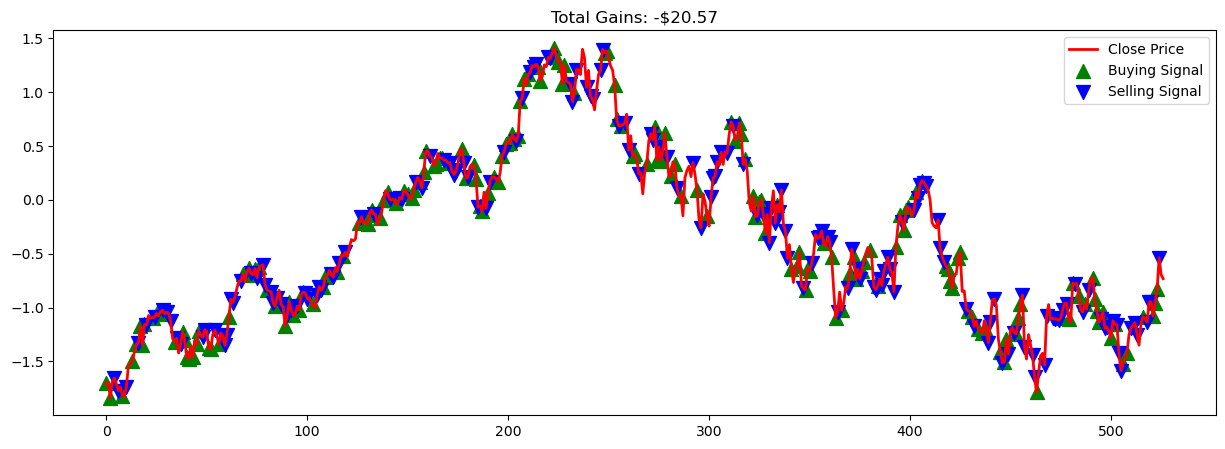

Running episode 9/10
Buy: -$1.70
Sell: -$1.70 | Profit: $0.01
Buy: -$1.77
Buy: -$1.74
Sell: -$1.82 | Profit: -$0.05
Buy: -$1.73
Buy: -$1.50
Sell: -$1.41 | Profit: $0.33
Sell: -$1.34 | Profit: $0.39
Buy: -$1.32
Buy: -$1.35
Buy: -$1.16
Sell: -$1.07 | Profit: $0.42
Sell: -$1.09 | Profit: $0.24
Sell: -$1.08 | Profit: $0.27
Sell: -$1.04 | Profit: $0.12
Buy: -$1.04
Buy: -$1.05
Sell: -$1.12 | Profit: -$0.08
Sell: -$1.28 | Profit: -$0.23
Buy: -$1.28
Buy: -$1.42
Buy: -$1.34
Sell: -$1.22 | Profit: $0.06
Buy: -$1.30
Buy: -$1.36
Buy: -$1.30
Buy: -$1.25
Buy: -$1.28
Sell: -$1.22 | Profit: $0.20
Sell: -$1.39 | Profit: -$0.05
Buy: -$1.21
Sell: -$1.34 | Profit: -$0.04
Buy: -$1.24
Buy: -$1.25
Sell: -$1.09 | Profit: $0.27
Buy: -$0.95
Sell: -$0.90 | Profit: $0.40
Sell: -$0.75 | Profit: $0.50
Sell: -$0.75 | Profit: $0.52
Buy: -$0.69
Buy: -$0.63
Sell: -$0.69 | Profit: $0.51
Buy: -$0.64
Sell: -$0.72 | Profit: $0.51
Buy: -$0.62
Sell: -$0.85 | Profit: $0.41
Sell: -$0.95 | Profit: -$0.00
Sell: -$0.99 | Profit: 

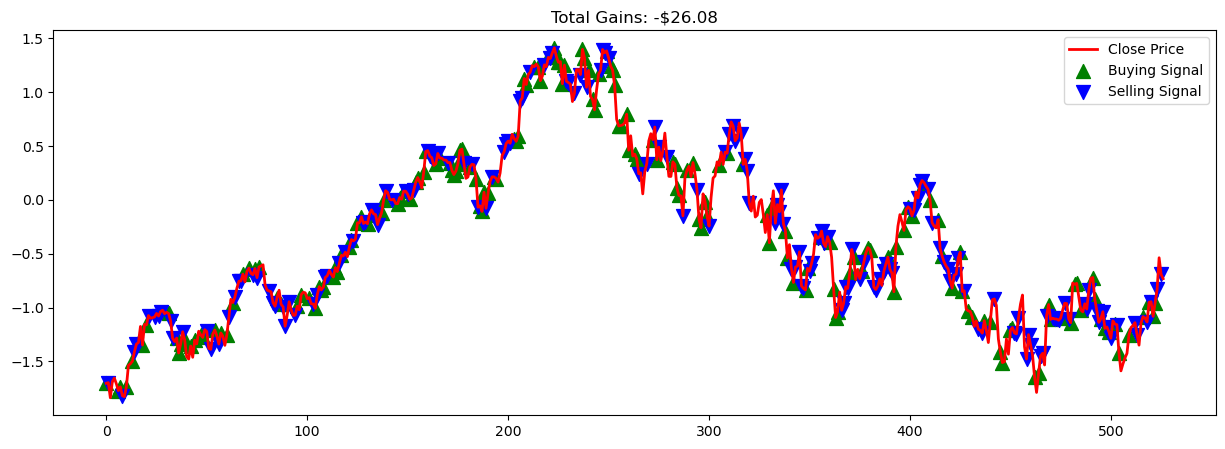

Running episode 10/10
Buy: -$1.70
Buy: -$1.70
Sell: -$1.84 | Profit: -$0.14
Sell: -$1.65 | Profit: $0.04
Buy: -$1.73
Buy: -$1.54
Buy: -$1.50
Buy: -$1.41
Sell: -$1.34 | Profit: $0.39
Sell: -$1.32 | Profit: $0.21
Sell: -$1.16 | Profit: $0.34
Buy: -$1.07
Sell: -$1.10 | Profit: $0.31
Sell: -$1.09 | Profit: -$0.01
Buy: -$1.05
Buy: -$1.04
Buy: -$1.06
Buy: -$1.04
Buy: -$1.12
Buy: -$1.32
Buy: -$1.28
Sell: -$1.42 | Profit: -$0.37
Sell: -$1.34 | Profit: -$0.30
Buy: -$1.22
Sell: -$1.30 | Profit: -$0.24
Buy: -$1.36
Buy: -$1.30
Buy: -$1.25
Buy: -$1.20
Buy: -$1.22
Sell: -$1.38 | Profit: -$0.33
Buy: -$1.25
Sell: -$1.34 | Profit: -$0.21
Sell: -$1.24 | Profit: $0.08
Buy: -$1.27
Sell: -$1.35 | Profit: -$0.07
Sell: -$1.25 | Profit: -$0.03
Buy: -$1.09
Sell: -$0.92 | Profit: $0.43
Sell: -$0.82 | Profit: $0.48
Buy: -$0.75
Sell: -$0.76 | Profit: $0.49
Buy: -$0.66
Sell: -$0.63 | Profit: $0.57
Buy: -$0.68
Buy: -$0.64
Sell: -$0.72 | Profit: $0.50
Buy: -$0.60
Buy: -$0.79
Sell: -$0.84 | Profit: $0.41
Buy: -$0.85


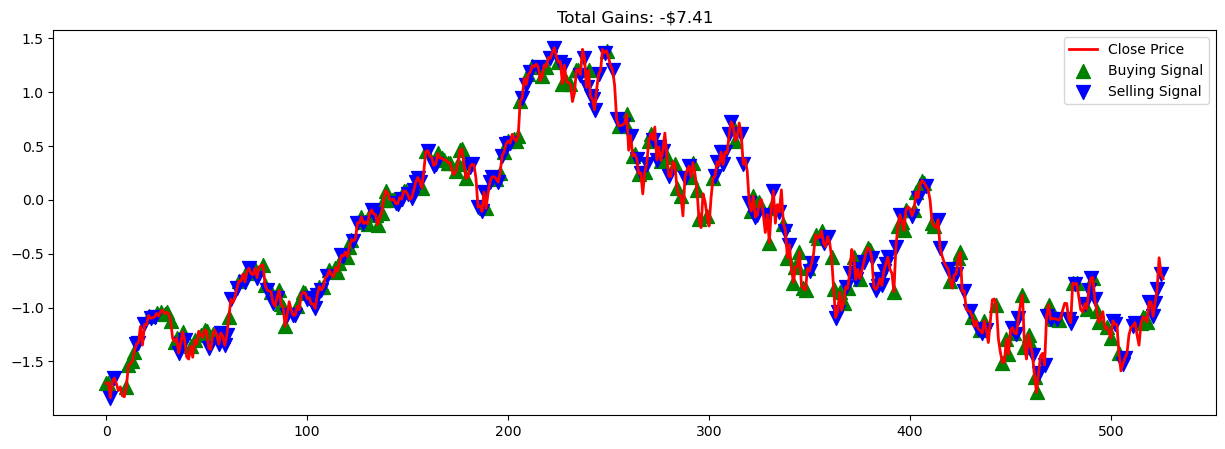

In [37]:
# Main code to run the training loop
window_size = 1  # This should reflect the number of timesteps each state considers
feature_count = 6  # Number of features per timestep
state_size = window_size * feature_count

# Instantiate the agent
agent = Agent(state_size=state_size, window_size=window_size)

#In this step we feed the closing value of the stock price
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print(f"Running episode {e}/{episode_count}")
    state = getState(data, 0, window_size)
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)  # Agent takes an action
        next_state = getState(data, t + 1, window_size)  # Observe the next state
        reward = 0

        # Take action based on the current state
        if action == 1:  # Buy
            agent.inventory.append(data[t][3])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t][3]))

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t][3] - bought_price, 0)
            total_profit += data[t][3] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t][3]) + " | Profit: " + formatPrice(data[t][3] - bought_price))

        done = t == l - 1  # Check if we're at the end of the episode

        # Store the transition in memory
        agent.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform experience replay if the memory is sufficient
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

        # If done, print the total profit and plot the trades
        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data[:, 3], states_buy, states_sell, total_profit)

    # Save the model after each episode
    agent.model.save("model_ep" + str(e)+".keras")

Buy: $1.48
Sell: $1.51 | profit: $0.03
Buy: $1.18
Buy: $1.26
Sell: $1.22 | profit: $0.04
Sell: $1.18 | profit: -$0.08
Buy: $1.01
Sell: $1.00 | profit: -$0.01
Buy: $1.06
Buy: $1.12
Buy: $1.06
Sell: $1.17 | profit: $0.12
Sell: $1.12 | profit: -$0.00
Buy: $1.27
Buy: $1.12
Buy: $0.76
Buy: $0.72
Sell: $0.79 | profit: -$0.28
Sell: $0.86 | profit: -$0.41
Sell: $0.69 | profit: -$0.43
Sell: $0.82 | profit: $0.06
Sell: $0.76 | profit: $0.04
Buy: $1.15
Sell: $1.12 | profit: -$0.03
Buy: $1.33
Buy: $1.52
Buy: $1.58
Buy: $1.67
Buy: $1.82
Buy: $1.89
Sell: $1.87 | profit: $0.54
Sell: $2.04 | profit: $0.52
Sell: $2.11 | profit: $0.54
Sell: $2.17 | profit: $0.50
Buy: $2.11
Buy: $2.22
Buy: $2.28
Buy: $2.29
Sell: $2.42 | profit: $0.60
Sell: $1.99 | profit: $0.10
Buy: $2.04
Sell: $2.10 | profit: -$0.01
Sell: $2.23 | profit: $0.01
Sell: $2.16 | profit: -$0.12
Buy: $2.00
Buy: $2.21
Sell: $2.17 | profit: -$0.12
Sell: $2.21 | profit: $0.17
Sell: $2.17 | profit: $0.17
Buy: $2.22
--------------------------------

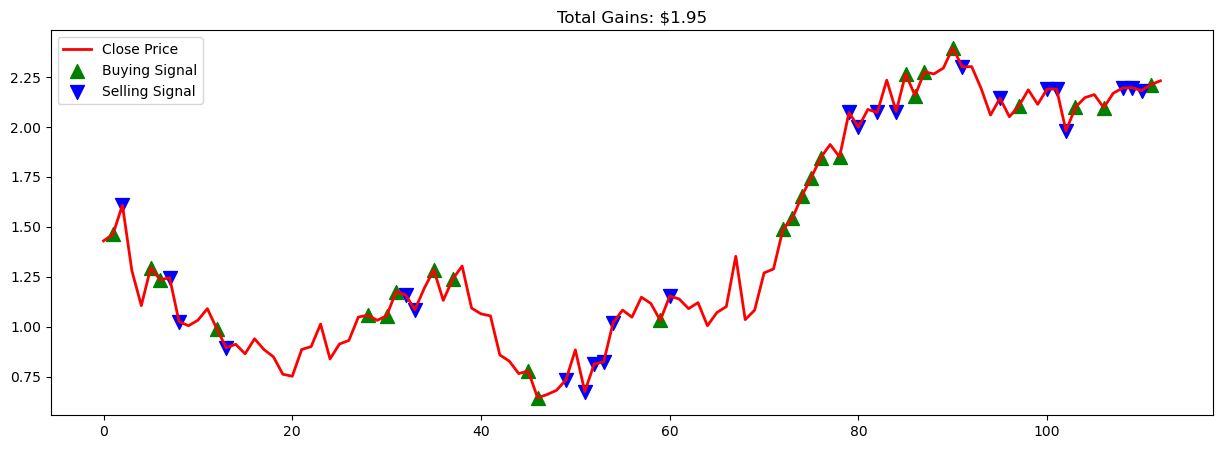

In [42]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(9)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
      agent.inventory.append(test_data[t][0])  # Assuming price is the first element
      states_buy_test.append(t)
      print("Buy: " + formatPrice(test_data[t][0]))  # Pass only the price to formatPrice

    elif action == 2 and len(agent.inventory) > 0:
      bought_price = agent.inventory.pop(0)
      current_price = test_data[t][0]  # Assuming price is the first element
      reward = max(current_price - bought_price, 0)
      total_profit += current_price - bought_price
      states_sell_test.append(t)
      print("Sell: " + formatPrice(current_price) + " | profit: " + formatPrice(current_price - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

plot_behavior(test_data[:, 3],states_buy_test, states_sell_test, total_profit)


In [41]:
def analyze_trades(buy_indices, sell_indices, prices):
    buy_prices = prices[buy_indices]
    sell_prices = prices[sell_indices]
    correct_buys = 0
    correct_sells = 0

    # Assume sells directly correspond to the buys before them
    for i in range(len(sell_indices)):
        if i < len(buy_indices) and sell_prices[i] > buy_prices[i]:
            correct_sells += 1
        if i > 0 and sell_prices[i] > buy_prices[i - 1]:
            correct_buys += 1

    return correct_buys, correct_sells

# Usage
correct_buys, correct_sells = analyze_trades(states_buy_test, states_sell_test, test_data[:, 3])
print(f"Correct Buys: {correct_buys} / {len(states_buy_test)}")
print(f"Correct Sells: {correct_sells} / {len(states_sell_test)}")

Correct Buys: 15 / 35
Correct Sells: 17 / 30


Buy: $1.37
Sell: $1.35 | profit: -$0.02
Buy: $1.18
Buy: $1.22
Buy: $1.18
Buy: $0.99
Buy: $1.05
Sell: $1.01 | profit: -$0.17
Buy: $0.99
Sell: $0.85 | profit: -$0.37
Buy: $0.88
Buy: $0.92
Buy: $0.86
Buy: $0.70
Sell: $0.79 | profit: -$0.39
Buy: $0.98
Sell: $0.94 | profit: -$0.05
Buy: $0.98
Buy: $1.06
Buy: $1.17
Sell: $1.12 | profit: $0.07
Sell: $1.32 | profit: $0.33
Buy: $1.26
Buy: $1.03
Buy: $1.08
Buy: $0.82
Sell: $0.87 | profit: -$0.00
Sell: $0.76 | profit: -$0.16
Sell: $0.72 | profit: -$0.14
Sell: $0.62 | profit: -$0.09
Buy: $0.75
Sell: $0.86 | profit: -$0.12
Sell: $0.82 | profit: -$0.16
Buy: $0.76
Buy: $0.96
Buy: $1.11
Buy: $1.12
Sell: $1.10 | profit: $0.04
Sell: $1.15 | profit: -$0.02
Buy: $0.98
Buy: $1.46
Buy: $1.10
Buy: $1.17
Sell: $1.33 | profit: $0.07
Sell: $1.52 | profit: $0.48
Buy: $1.58
Buy: $1.67
Sell: $1.82 | profit: $0.74
Sell: $1.89 | profit: $1.07
Sell: $1.87 | profit: $1.12
Buy: $2.11
Buy: $2.11
Sell: $2.22 | profit: $1.47
Buy: $2.28
Buy: $2.25
Buy: $2.29
Buy: $2.42
Sell

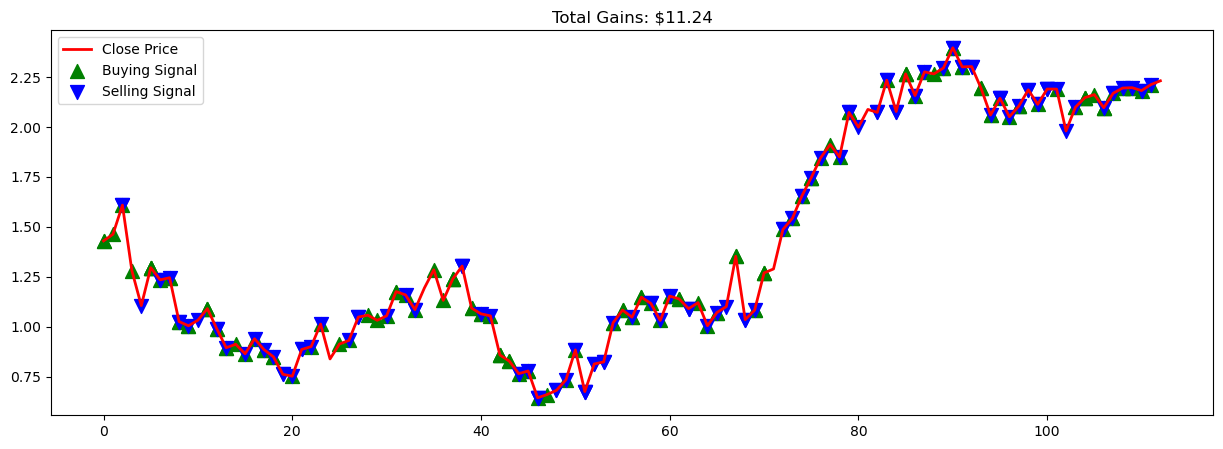

In [49]:

risk_free_rate = 0.01  # Annual risk-free rate to calculate Sharpe Ratio
sampling_rate = 252  # Trading days in a year, for daily Sharpe Ratio calculation

# Initialize test data and agent
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
model_name = "model_ep9"
agent = Agent(window_size, is_eval, model_name)  # Ensure Agent is properly defined/imported
agent.inventory = []
actions_taken = []
portfolio_values = []

import numpy as np

# Define additional metric variables
total_positive_profit = 0
total_negative_profit = 0
peak_profit = 0
maximum_drawdown = 0
total_trades = 0
profitable_trades = 0
total_losses = 0
trade_results = []
for t in range(l_test):
    action = agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:  # Buy
        agent.inventory.append(test_data[t][0])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t][0]))

    # Inside the loop
    if action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        current_price = test_data[t][0]
        profit = current_price - bought_price
        reward = max(profit, 0)
        total_profit += profit
        states_sell_test.append(t)
        print(f"Sell: {formatPrice(current_price)} | profit: {formatPrice(profit)}")
        
        trade_results.append(profit)
        if profit > 0:
            total_positive_profit += profit
            profitable_trades += 1
        else:
            total_negative_profit += abs(profit)
            total_losses += 1
    
        # Update drawdown
        if total_profit > peak_profit:
            peak_profit = total_profit
        drawdown = peak_profit - total_profit
        if drawdown > maximum_drawdown:
            maximum_drawdown = drawdown
    
        total_trades += 1

# After the loop
if total_trades > 0:
    profit_factor = total_positive_profit / total_negative_profit if total_negative_profit > 0 else float('inf')
    win_rate = profitable_trades / total_trades
    sharpe_ratio = (np.mean(trade_results) / np.std(trade_results) * np.sqrt(total_trades)) if np.std(trade_results) != 0 else float('inf')
else:
    profit_factor, win_rate, sharpe_ratio = float('inf'), 0, 0

print(f"Total Profit: {formatPrice(total_profit)}")
print(f"Profit Factor: {profit_factor}")
print(f"Maximum Drawdown: {formatPrice(maximum_drawdown)}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate:.2%}")
plot_behavior(test_data[:, 3], states_buy_test, states_sell_test, total_profit)

